
# Comparativa de mejores modelos (sin reentrenar)

Este cuaderno **no vuelve a entrenar** modelos. Carga **pipelines guardados** (RandomForest y XGBoost),
reconstruye el *split* `train/test` de forma reproducible y evalúa ambos sobre el **mismo** conjunto de test.
Incluye métricas, matrices de confusión, curvas ROC y una tabla comparativa.



## 1) Configuración

In [ ]:
from pathlib import Path

DATA_PATH = "api_logs_ml_ready.csv"
TARGET_COL = "label_attack"
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_JOBS = -1

RF_MODEL_PATHS = "random_forest_api_attack_detector_tuned.joblib"

XGB_MODEL_PATHS = "xgboost_api_attack_detector_tuned.joblib"

print("DATA_PATH:", DATA_PATH)
print("TARGET_COL:", TARGET_COL)


DATA_PATH: api_logs_ml_ready.csv
TARGET_COL: label_attack



## 2) Librerías


In [2]:

import warnings
warnings.filterwarnings("ignore")

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from joblib import load

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_score, recall_score, f1_score, accuracy_score
)


## 3) Utilidades


In [3]:

def load_pipeline(paths):
    return load(paths)

def positive_label_from_classes(classes):
    classes = list(classes)
    if 1 in classes:
        return 1
    try:
        return sorted(classes)[-1]
    except Exception:
        return classes[-1]

def evaluate_model(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_test, y_pred)
    metrics["precision_macro"] = precision_score(y_test, y_pred, average="macro", zero_division=0)
    metrics["recall_macro"] = recall_score(y_test, y_pred, average="macro", zero_division=0)
    metrics["f1_macro"] = f1_score(y_test, y_pred, average="macro", zero_division=0)
    metrics["precision_weighted"] = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    metrics["recall_weighted"] = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    metrics["f1_weighted"] = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n=== {name} ===")
    print("Classification report:\n")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print("Matriz de confusión:\n", cm)
    
    # Plot CM
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(f"Matriz de confusión - {name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    # Si binario, etiquetar 0/1; si no, usar rangos
    n_classes = len(np.unique(y_test))
    ax.set_xticks(range(n_classes))
    ax.set_yticks(range(n_classes))
    ax.set_xticklabels([str(c) for c in sorted(np.unique(y_test))])
    ax.set_yticklabels([str(c) for c in sorted(np.unique(y_test))])
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center')
    fig.colorbar(im, ax=ax)
    plt.show()
    
    classes = pipe.named_steps[list(pipe.named_steps.keys())[-1]].classes_
    
    try:
        proba = pipe.predict_proba(X_test)
        pos_label = positive_label_from_classes(classes) if classes is not None else 1
        pos_idx = list(classes).index(pos_label) if classes is not None else 1
        auc = roc_auc_score(y_test, proba[:, pos_idx])
        metrics["roc_auc"] = auc
        RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name, pos_label=pos_label)
        plt.title(f"Curva ROC - {name}")
        plt.show()
    except Exception as e:
        print(f"No se pudo calcular/trazar ROC para {name}:", e)
    
    return metrics



## 4) Carga de datos y reconstrucción de los datos de entrenamiento y test

In [4]:

df = pd.read_csv(DATA_PATH)
assert TARGET_COL in df.columns, f"No existe la columna objetivo '{TARGET_COL}' en el dataset."

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

stratify = y if (y.nunique() <= 20) else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify
)
print("Shapes X_train/X_test:", X_train.shape, X_test.shape)


Shapes X_train/X_test: (2878, 15) (720, 15)



## 5) Cargar los **mejores pipelines** guardados


In [5]:

rf_pipe = None
xgb_pipe = None

try:
    rf_pipe = load_pipeline(RF_MODEL_PATHS)
except Exception as e:
    print("Error: no se pudo cargar el modelo RandomForest:", e)

try:
    xgb_pipe = load_pipeline(XGB_MODEL_PATHS)
except Exception as e:
    print("Error: no se pudo cargar el modelo XGBoost:", e)

if (rf_pipe is None) and (xgb_pipe is None):
    raise RuntimeError("No se pudo cargar ningún modelo. Revisa las rutas en RF_MODEL_PATHS / XGB_MODEL_PATHS.")



## 6) Evaluación y comparativa
Se evalúan ambos modelos sobre **el mismo** `X_test`/`y_test`. Se construye una tabla con métricas clave y, si es binario, también **ROC-AUC**.



=== RandomForest ===
Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       480
           1     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       720
   macro avg     1.0000    1.0000    1.0000       720
weighted avg     1.0000    1.0000    1.0000       720

Matriz de confusión:
 [[480   0]
 [  0 240]]


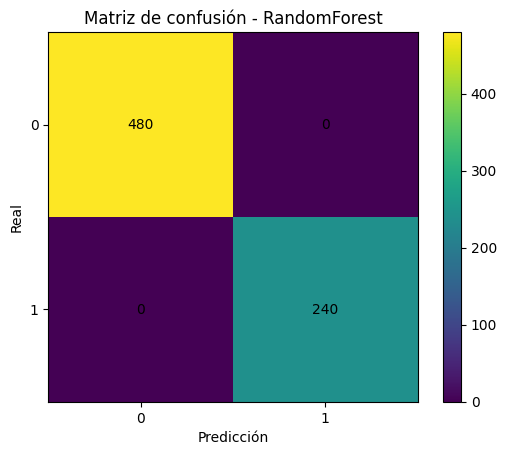

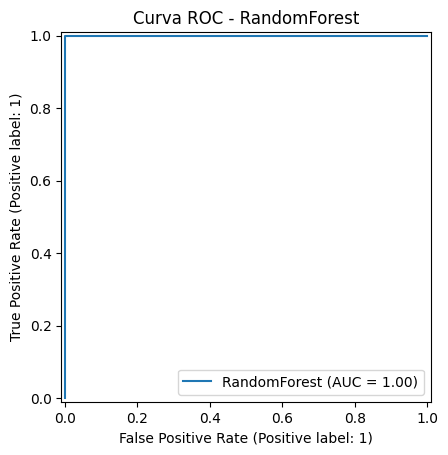


=== XGBoost ===
Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       480
           1     1.0000    1.0000    1.0000       240

    accuracy                         1.0000       720
   macro avg     1.0000    1.0000    1.0000       720
weighted avg     1.0000    1.0000    1.0000       720

Matriz de confusión:
 [[480   0]
 [  0 240]]


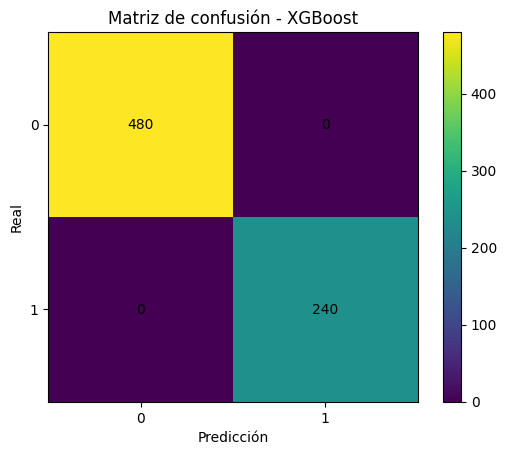

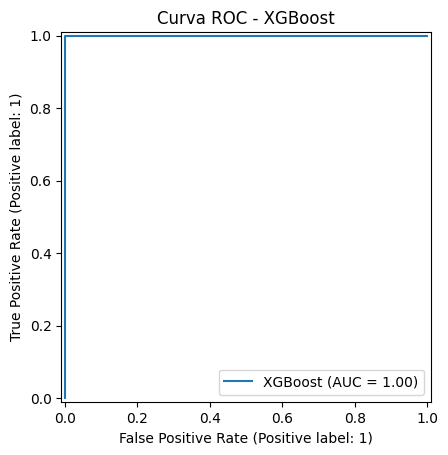

,accuracy,f1_macro,f1_weighted,precision_macro,precision_weighted,recall_macro,recall_weighted,roc_auc
RandomForest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
XGBoost,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Guardado: outputs_compare/comparativa_metricas.csv


In [ ]:

results = {}
if rf_pipe is not None:
    results["RandomForest"] = evaluate_model("RandomForest", rf_pipe, X_test, y_test)
if xgb_pipe is not None:
    results["XGBoost"] = evaluate_model("XGBoost", xgb_pipe, X_test, y_test)

# Tabla comparativa
if results:
    metrics_sorted = sorted({m for d in results.values() for m in d.keys()})
    df_cmp = pd.DataFrame({name: {m: results[name].get(m, np.nan) for m in metrics_sorted} for name in results}).T
    display(df_cmp)



## 7) Conclusiones
- Se han cargado los mejores pipelines guardados y evaluado sin reentrenar.
- La tabla `comparativa_metricas.csv` contiene las métricas principales por modelo.
- Las curvas ROC (si el problema es binario) permiten comparar la discriminación de ambos.
